# How to Train an Autoencoder for single-cell RNA-seq data
<img src="imgs/DCA_paper_Fig1.png" class="center" width=500/>

**Authorship:**
Adam Klie, *01/22/2022*
***
**Description:**
Notebook template for building and training an deep count autoencoder (DCA) for single-cell omics analysis

**Notes:**
 - **Environment:** You need a Jupyter `python3` kernel with PyTorch and Sklearn installed. [See instructions for setup here.](https://github.com/adamklie/CLAIM-scAEs#environment-setup)
 - **GPU Usage:** The default data and model used below are lightweight enough to be trained on a cpu, but if you'd like to train on a larger dataset with more parameters, we recommend opening a GPU backed notebook. If you are using the `ml_env` kernel described in the above environment setup, you simply need to run the following after logging onto the cluster:
 
 ```bash
 module load cuda10.2
jupyter-submit -p carter-gpu -A carter-gpu -t 05-00:00:00 -c 4 -m 16G -g 1 -I
```
***

# Setup Packages
Here we load the typical base packages we will utilize throughout the exercise. We will also need to import the PyTorch library and check if we are on a GPU node.

In [1]:
# Classic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(13)

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

  If you are on a GPU, the function will return `True` and will tell you which GPU(s) you are using.

In [2]:
import torch
print("Using a GPU? {}".format(torch.cuda.is_available()))
if torch.cuda.is_available():
    print("Device number [0-7]: {}".format(torch.cuda.current_device()))
    print("Device count: {}".format(torch.cuda.device_count()))

Using a GPU? True
Device number [0-7]: 0
Device count: 1


In [3]:
# You can use this variable to keep track of how many epochs you've trained a model for
epochs_trained = 0

# Load dataset
Here we load the **pbmc3k** dataset. This dataset captures Peripheral Blood Mononuclear Cells (PBMC) freely available from 10X Genomics. There were originally 2,700 single cells that were sequenced on the Illumina NextSeq 500. Here we load in both the raw and normalized counts for the variable genes. See the `Collect_Datasets_and_Preprocess_DCA.ipynb` and `Collect_Cell_Type_Labels.ipynb` notebooks for more details on the dataset and the preprocessing steps applied.

In [49]:
raw_counts = np.load("data/pbmc3k_DCA_counts.npy")
norm_counts = np.load("data/pbmc3k_DCA.npy")
scale_factors = np.load("data/pbmc3k_sfs.npy")
num_cells = norm_counts.shape[0] # rows
num_genes = norm_counts.shape[1] # columns

if raw_counts.shape == norm_counts.shape and scale_factors.shape[0] == num_cells:
    print("Dataset contains:\n" + \
        "\tRaw counts: {0} genes across {1} cells\n".format(num_genes, num_cells) + \
        "\tNormalized counts: {0} genes across {1} cells\n".format(num_genes, num_cells) + \
        "\tScale factors for: {} cells".format(num_cells))
else:
    print("Differing number of cells or genes in raw and normlaized counts")

Dataset contains:
	Raw counts: 1870 genes across 2700 cells
	Normalized counts: 1870 genes across 2700 cells
	Scale factors for: 2700 cells


## Instantiate the dataloader
[DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) are fundamental PyTorch objects that interface the data you want to train with to the model you want to train. A DataLoader is essentially a Python iterator that can be looped through to pull "batches" of data at time. These "batches" of data are passed to the model during training. 

In [5]:
from torch.utils.data import TensorDataset, DataLoader

In [6]:
# Build a TensorDataset object from the scaled array, note that PyTorch likes Tensors, not numpy arrays
dataset = TensorDataset(torch.from_numpy(raw_counts), torch.from_numpy(norm_counts), torch.from_numpy(scale_factors))

In [7]:
# Build a simple DataLoaders from the Dataset object
loader = DataLoader(dataset, batch_size=256, shuffle=False)

In [8]:
# Check dims of loaders for correctness (should match n_cells x torch.Size(n_genes))
print("Dimensions of training set: {} x {}".format(len(loader.dataset), loader.dataset[0][0].shape))

Dimensions of training set: 2700 x torch.Size([1870])


In [9]:
# Test a yield, should be raw counts, normalized and z-scored counts and scale factors
loader.dataset[0]

(tensor([0., 0., 0.,  ..., 1., 0., 4.]),
 tensor([-0.7581, -0.2309, -0.2530,  ...,  0.3737, -0.2988,  0.1337]),
 tensor(1.1020))

# The autoencoder model
Here we initialize a predefined autoencoder architecture (see `autoencoders.py`). The encoder's job is to take an input vector and output a lower-dimensional latent embedding; the decoder does the opposite, taking the latent embedding to reconstruct/output the input vector. The decoder architecture is a mirror of the encoder's. The input size of the encoder corresponds to the dimensions of our features (variable genes) and outputs a latent embedding of size 10. 

We initialize the weights using a Kaiming Uniform or He initialization (see `init_weights.py`). Each linear layer is activated with the ReLU function.

<div class="alert alert-block alert-info">
<b>TODO</b>

We provide the most basic autoencoder architecture here. This is your opportunity to explore parameters i.e. the number of hidden layers, the width per layer, etc. or try something completely different!
</div>

In [10]:
# Load predefined model and weight initializer
from scripts.utils import init_weights
from scripts.dca import DCA

In [14]:
# Instantiate model and move to gpu if available
model = DCA(norm_counts.shape[1], hidden=2)
model.apply(init_weights)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Executing the model on:", device)
model.to(device)

Executing the model on: cuda


DCA(
  (encoder): Sequential(
    (0): Linear(in_features=1870, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
  )
  (pi): Linear(in_features=512, out_features=1870, bias=True)
  (mean): Linear(in_features=512, out_features=1870, bias=True)
  (disp): Linear(in_features=512, out_features=1870, bias=True)
)

Let's check what our model looks like, using a handy summary function.

In [15]:
from torchinfo import summary

In [16]:
# We will assume a batch size of 256. 
# The summary function expects you to include the expected input size as a parameter along with a batch size
summary(model, input_size=(256, num_genes))

Layer (type:depth-idx)                   Output Shape              Param #
DCA                                      --                        --
├─Sequential: 1-1                        [256, 2]                  --
│    └─Linear: 2-1                       [256, 512]                957,952
│    └─ReLU: 2-2                         [256, 512]                --
│    └─Linear: 2-3                       [256, 128]                65,664
│    └─ReLU: 2-4                         [256, 128]                --
│    └─Linear: 2-5                       [256, 2]                  258
├─Sequential: 1-2                        [256, 512]                --
│    └─Linear: 2-6                       [256, 128]                384
│    └─ReLU: 2-7                         [256, 128]                --
│    └─Linear: 2-8                       [256, 512]                66,048
│    └─ReLU: 2-9                         [256, 512]                --
├─Linear: 1-3                            [256, 1870]               959

Next let's test out our autoencoder structure with our initialized parameters. You can use the following code block to check to see if things are being output the way you would expect. By default, the encoded dimension size should be 10 and the size of the decoded dimesion should match the variable genes.

In [17]:
# Grab some seqs and outputs to test out on
indexes = np.random.choice(norm_counts.shape[1], size=5)
random_cells = torch.from_numpy(norm_counts[indexes]).float().to(device)

# Feed through encoder and to get bottleneck size
encoded_outputs = model.encoder(random_cells).squeeze(dim=1)

# Feed through encoder and decoder to get full output size
outputs = model(random_cells)[0].squeeze(dim=1)
print("Encoder output dimension: {}\nDecoder output dimension: {}".format(encoded_outputs.shape[1], outputs.shape[1]))

Encoder output dimension: 2
Decoder output dimension: 1870


# Set training optimization parameters

Before we train our model, we need to instantiate a loss function that we are aiming to optimize and an algorithm for conducting that optimization. Here we use **MSE loss** to model the reconstruction of gene expression counts, and optimize using the **adaptive momentum (Adam) algorithm**. MSE and Adam are popular in deep learning (don't worry, I'm no DanQ), but feel free to play with others or define your own!

<div class="alert alert-block alert-info">
<b>TODO</b>
    
Try out different optimization strategies and loss functions. This is general to neural networks and not specific to autoencoders, but still an important set of hyperparameters to consider.

 - PyTorch optimizers: https://pytorch.org/docs/stable/optim.html
 - PyTorch loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions
</div>

In [18]:
import torch.nn as nn
from scripts.dca import ZINBLoss

In [26]:
# Define the optimizer, filter just gaurentees that optimized doesn't try to optimized a parameter it shouldn't
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, amsgrad=True)

In [22]:
# Define the loss function
criterion = ZINBLoss().to(device)

ZINBLoss()

# Test out the configuration of DCA
This model is a little more complex than the Vanilla AE we previously implemented. So we just want to run some sanity checks to make sure things are behaving as expected.

In [50]:
from scripts.dca import test_config

In [55]:
test_config(model=model, dataloader=loader, criterion=criterion, optimizer=optimizer, device=device)

Loss before test optimization: 0.30529457330703735
There are gradients and they have changed
Parameters have changed
Loss after test optimization: tensor(0.2864, device='cuda:0', grad_fn=<MeanBackward0>)
Did it go down?


# Train the model
Here we actually optimize our defined loss function via our autoencoder inputs and reconstructions. We are making use of a training function designed for autoencoders that can be found in the `train.py` file. We will also use the livelossplot package to visualize our loss across training. If all goes well, you should see loss decrease at each epoch (aka iteration through the dataset), something along the lines of:

![loss_plot](imgs/example_loss.png)

<div class="alert alert-block alert-info">
<b>TODO: Make-it-train!</b>
    
Define the number of epochs and how often to update the loss plot (default every 10 epochs). Note that updating too often will slow down training.
<hr>
<b>A note on training time:</b>
    
Using the given dataset, model architecture and learning rate, training is very fast. We were able to train a model for 1000 epochs in less than a minute on a GPU!
</div>

In [23]:
from scripts.dca import train_DCA
import time

In [24]:
num_epochs = 1000
plot_frequency = 100

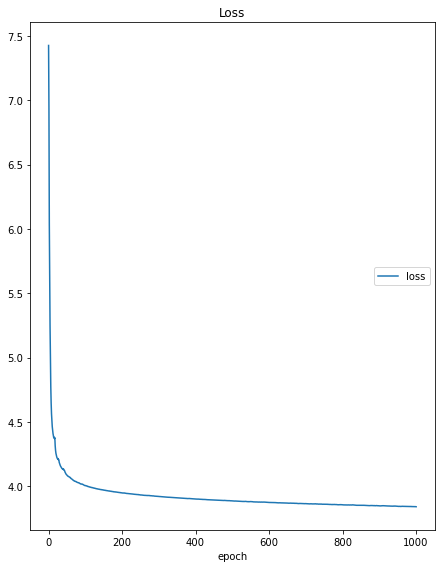

Loss
	loss             	 (min:    3.841, max:    7.425, cur:    3.841)
Trained 1000 epochs in 100.5963 seconds


In [27]:
# Make-it-train!
tic = time.perf_counter()
loss_history, _ = train_DCA(model=model, 
                                    dataloader=loader, 
                                    criterion=criterion, 
                                    optimizer=optimizer,
                                    device=device,
                                    num_epoch=num_epochs,
                                    plot_frequency=plot_frequency)
toc = time.perf_counter()
epochs_trained += num_epochs
print(f"Trained {num_epochs:d} epochs in {toc - tic:0.4f} seconds")

## Save trained model
If you are happy with your model, save it's parameters. You can always load it in later for interpretation or to do more training.

In [28]:
import os

In [29]:
if not os.path.exists("models"):
    os.makedirs("models")
torch.save(model.state_dict(), "models/DCA_{}.pt".format(epochs_trained))

# Visualize latent space
We are now ready to investigate that latent space our model has learned. We leave coming up with an awesome new analysis to the user, but we wrote some code for you to generate a two dimensional visualization of your latent space using both PCA and UMAP reduction. We added cell-type labels from the [Seurat guided clustering tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html). Do you see separation between Seurat's cell-type labels?

<div class="alert alert-block alert-info">
<b>TODO: Visualize</b>
    
Use and modify the `visualize()` function to plot our model's embedding.
</div>

In [30]:
from scripts.utils import visualize

In [31]:
latent_data = model.encoder(loader.dataset.tensors[0].float().to(device)).detach().cpu().numpy()

In [56]:
# Get the cellids
metadata = pd.read_csv("data/pbmc3k_SeuratMetadata.tsv", sep="\t")
cell_ids = np.loadtxt("data/pbmc3k_cellids.txt", dtype=str)
cell_ids = pd.Index([col.split("-")[0] for col in cell_ids])

In [37]:
latent_data = latent_data[pd.Index(cell_ids).isin(metadata.index)]
cell_ids = cell_ids[pd.Index(cell_ids).isin(metadata.index)]
if not latent_data.shape == len(cell_ids):
    print("Something is rotten in the state of Denmark")

Latent space is already 2 dimensions, just plotting


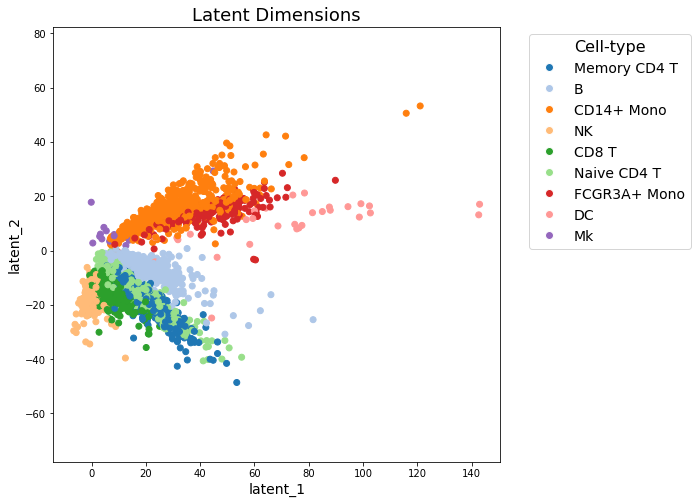

In [42]:
visualize(latent_embedding=latent_data, cellids=cell_ids, metadata_file="data/pbmc3k_SeuratMetadata.tsv")

# Saving denoised counts

In [57]:
means = model(loader.dataset.tensors[0].float().to(device))[0].detach().cpu().numpy()

In [60]:
np.save("data/pbmc3k_dca", means)

## So how'd you do?

Since we used Scanpy to download the data, we will start by comparing to them. Here's what Scanpy's tutorial outputs on 40 PCs, 10 nearest neighbors and default UMAP settings. They use the same preprocessing strategy we used for this tutorial.

![scanpy_pbm3k](imgs/pbmc3k_100_1.png)

What about Seurat? They have a slightly different pipeline. These were the labels you used for you visualization as well!

![seurat_pbm3k](imgs/pbmc3k_Seurat.png)

# References